NoFilter 100% selective had 10/60 pareto points
Kath18, max 33% selective had 6/60 pareto points
Stale-SB (n=3), 33% selective had 31/60 pareto points
SB, 33% selective had 12/60 pareto points
Random, 33% selective had 1/60 pareto points
../plots//sysml20/pareto//hull-cifar10.pdf


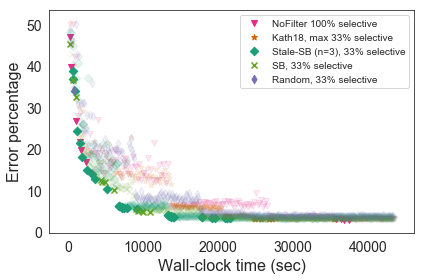

KeyboardInterrupt: 

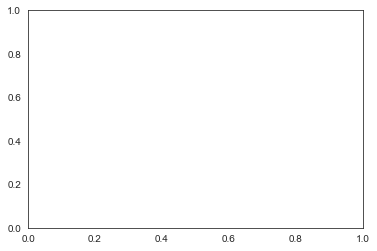

In [63]:
%run SysML20.ipynb

In [509]:
# selectivity=2.0
datasets = ["svhn"]
datasets += ["cifar10", "cifar100"]
filenames = []

# selects = {
#     "cifar10": ["2.0"], #["1.0", "2.0"], # 50 33
#     "cifar100": ["1.0"], #["1.0", "2.0"],  # 50% 33%
#     "svhn": ["3.0"],# ["2.0", "3.0", "4.0"], # 33 25 20
# }

selects = {
    "cifar10": ["1.0", "2.0"], # 50 33
    "cifar100": ["1.0", "2.0"],  # 50% 33%
    "svhn": ["2.0", "3.0", "4.0"], # 33 25 20
}


for dataset in datasets:
    for bs in [128]:
        filenames.append([dataset, bs, 0, "data/output/{ds}/190904_lr1/nofilter_{ds}_wideresnet_0_{bs}_1024_3_trial1_seed1337_v5".format(ds=dataset, bs=bs)])
        for method in ["sb-relative-alwayson", "sb-relative-stale3"]:
            for select in selects[dataset]:
                filenames.append([dataset, bs, select, "data/output/{ds}/190904_lr1/{method}_{ds}_wideresnet_0_{bs}_1024_{sel}_trial1_seed1337_v5".format(ds=dataset, bs=bs, sel=select, method=method)])
# svhn narwhal
# cifar orca


In [510]:
times = {
    'cifar10': {
        64: {
            'backward': 0.418406,
            'forward': 0.223362,
            'forward-sb': 0.213141,
        },
        128: {
            'backward': 0.334084,
            'forward': 0.161813,
            'forward-sb': 0.150395,
        }
    },
    'cifar100': {
      128: {
          'backward': 0.334021,
          'forward': 0.160724,
          'forward-sb': 0.150113,
      }  
    },
    'svhn': {
        64: {
            'backward': 0.152050,
            'forward':0.074837,
            'forward-sb': 0.071023,
        },
        128: {
            'backward': 0.284337,
            'forward': 0.134878,
            'forward-sb': 0.128225,
        }

    }
}
# batchsize = 128
# times = times['svhn'][batchsize]

def parse(nameeee):
    rows = []
    last_vals = [0] * 4
    train_lines, test_lines = parse_file("../"+nameeee)
    for line in test_lines:
#         time_est = line.num_backprop / batchsize * times['backward'] + line.num_forwards / batchsize * times['forward-sb']
        curr_vals = [line.num_backprop, line.num_skip, line.num_forwards, line.seconds_elapsed]
        rows.append([line.epoch, line.acc] + [x-y for x,y in zip(curr_vals, last_vals)] + curr_vals)
        last_vals = curr_vals
#         print(line.epoch, line.num_backprop, line.num_skip, line.num_forwards,
#               line.seconds_elapsed,
#              time_est / line.seconds_elapsed)
    return rows

In [511]:
import pandas as pd

def get_df(rows, times_, bs, nofilter=False):
    times = dict(times_)
    if nofilter:
        times['forward-sb'] = 0
    vc = ['num_backprop', 'num_skip', 'num_forwards', 'seconds_elapsed']
    df = pd.DataFrame(rows, columns=['epoch', 'acc'] + vc + ['cum_'+k for k in vc])
    df['est_cum_backward'] = df['cum_num_backprop'] / bs * times['backward']
    df['est_cum_forward'] = df['cum_num_backprop'] / bs * times['forward']
    df['est_cum_forwardsb'] = df['cum_num_forwards'] / bs * times['forward-sb']
    df['est_cum_time'] = df['est_cum_backward'] + df['est_cum_forward'] + df['est_cum_forwardsb']
    df['est_backward'] = df['num_backprop'] / bs * times['backward']
    df['est_forward'] = df['num_backprop'] / bs * times['forward']
    df['est_forwardsb'] = df['num_forwards'] / bs * times['forward-sb']
    df['estimated_time'] = df.apply(lambda x: x['num_backprop'] / bs * (times['backward']+times['forward']) + x['num_forwards'] / bs * times['forward-sb'], axis=1)
    # df['estimated_time_nofilter'] = df.apply(lambda x: x['num_backprop'] / batchsize * (times['backward']+times['forward']), axis=1)

    df['ratio'] = df['estimated_time'] / df['seconds_elapsed']
#     df['ratio_est'] = df['estimated_time']*(1/0.92324586555875787) / df['seconds_elapsed']
    df['ratio_backward'] = df['est_backward'] / df['estimated_time']
    df['ratio_forward'] = df['est_forward'] / df['estimated_time']
    df['ratio_forwardsb'] = df['est_forwardsb'] / df['estimated_time']
    df['ratio_backwardtot'] = (df['est_backward']+df['est_forward']) / df['estimated_time']
    # +df['est_forward']
    return df

In [512]:
from collections import defaultdict, OrderedDict
dfs = defaultdict(OrderedDict)
for dataset, bs, select, fn in filenames:
    print(fn)
    rows = parse(fn)
    df = get_df(rows, times[dataset][bs], bs, nofilter="nofilter" in fn)
    if "stale3" in fn:
        df = df[df['epoch'] % 3 == 0]
    dfs[dataset][(select, fn)] = df

data/output/svhn/190904_lr1/nofilter_svhn_wideresnet_0_128_1024_3_trial1_seed1337_v5
data/output/svhn/190904_lr1/sb-relative-alwayson_svhn_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
data/output/svhn/190904_lr1/sb-relative-alwayson_svhn_wideresnet_0_128_1024_3.0_trial1_seed1337_v5
data/output/svhn/190904_lr1/sb-relative-alwayson_svhn_wideresnet_0_128_1024_4.0_trial1_seed1337_v5
data/output/svhn/190904_lr1/sb-relative-stale3_svhn_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
data/output/svhn/190904_lr1/sb-relative-stale3_svhn_wideresnet_0_128_1024_3.0_trial1_seed1337_v5
data/output/svhn/190904_lr1/sb-relative-stale3_svhn_wideresnet_0_128_1024_4.0_trial1_seed1337_v5
data/output/cifar10/190904_lr1/nofilter_cifar10_wideresnet_0_128_1024_3_trial1_seed1337_v5
data/output/cifar10/190904_lr1/sb-relative-alwayson_cifar10_wideresnet_0_128_1024_1.0_trial1_seed1337_v5
data/output/cifar10/190904_lr1/sb-relative-alwayson_cifar10_wideresnet_0_128_1024_2.0_trial1_seed1337_v5
data/output/cifar10/190904

In [513]:
# dfs['data/output/svhn/190904_lr1/sb-relative-stale3_svhn_wideresnet_0_128_1024_2.0_trial1_seed1337_v5']
# dfs['data/output/svhn/190904_lr1/nofilter_svhn_wideresnet_0_128_1024_3_trial1_seed1337_v5']
# dfs['data/output/svhn/190904_lr1/sb-relative-alwayson_svhn_wideresnet_0_128_1024_2.0_trial1_seed1337_v5']

OrderedDict()

In [514]:
def e_acc(qwe):
    return [kk.acc.max() for kk in qwe.values()]
# print e_acc(dfs['cifar10'])

for ds in ['cifar10', 'cifar100', 'svhn']:
#     for select, dcc in dfs[ds].items():
    dcc = dfs[ds]
    accs = e_acc(dcc)
    print(ds, [100-x for x in accs])
    best_acc = max(accs)


('cifar10', [2.9599999999999937, 3.0100000000000051, 3.2399999999999949, 3.2000000000000028, 3.3700000000000045])
('cifar100', [18.209999999999994, 19.359999999999999, 20.099999999999994, 19.450000000000003, 20.359999999999999])
('svhn', [1.7209589999999935, 1.471266, 1.4174859999999967, 1.4021199999999965, 1.4981559999999945, 1.4751080000000059, 1.4943150000000003])


('cifar10', 5)
0.41
96.448
95.856
('cifar100', 5)
2.15
78.148
74.506
('svhn', 7)
0.318839
97.9348492
97.5906574


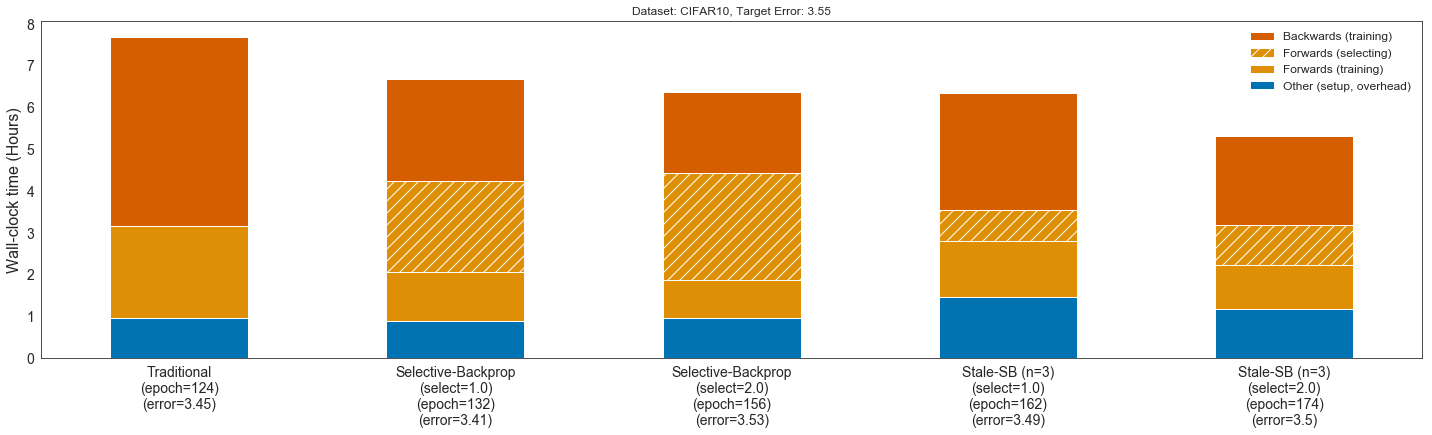

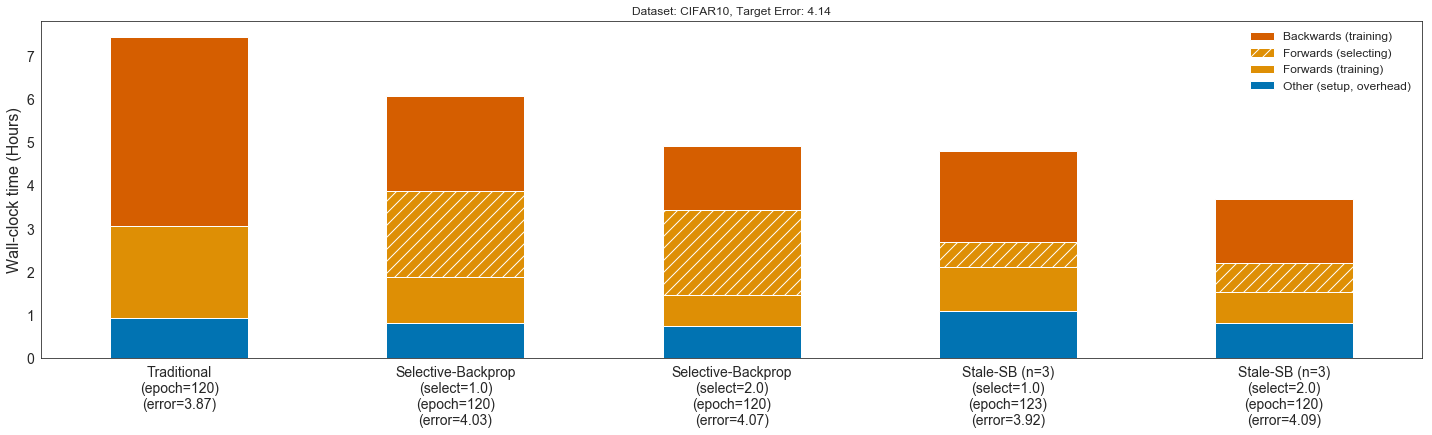

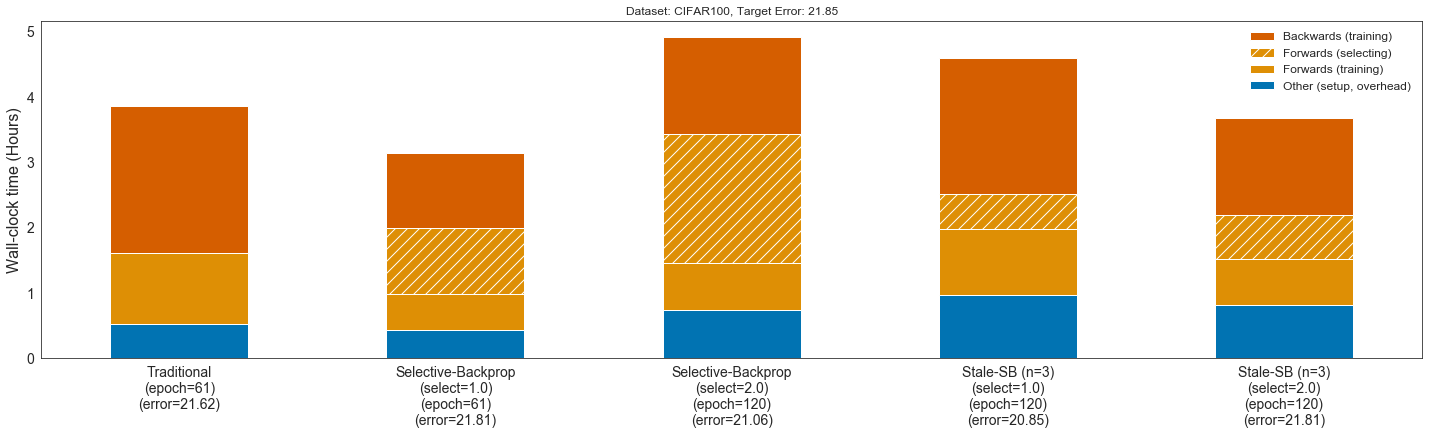

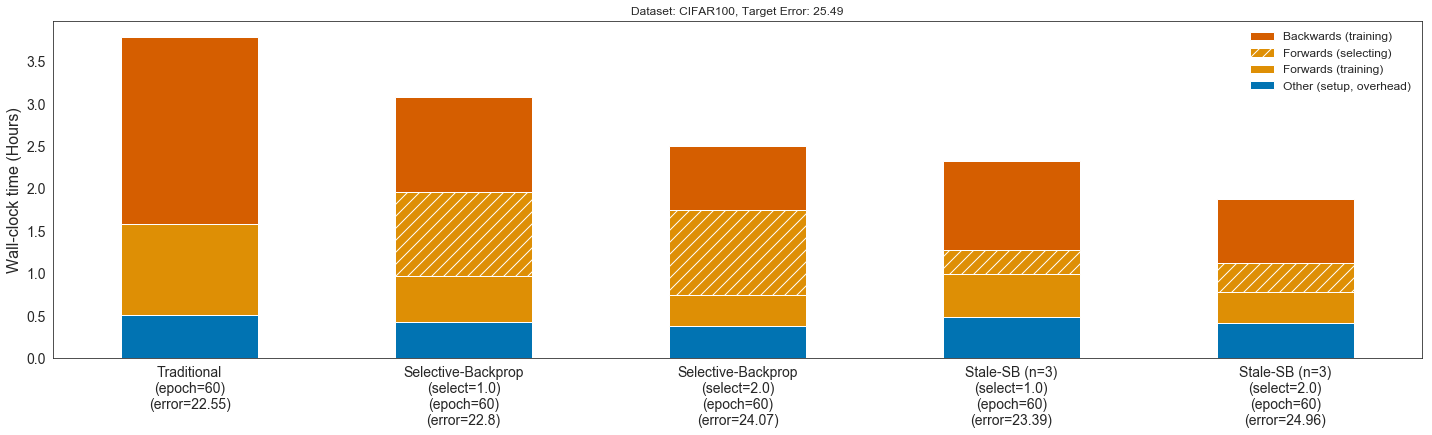

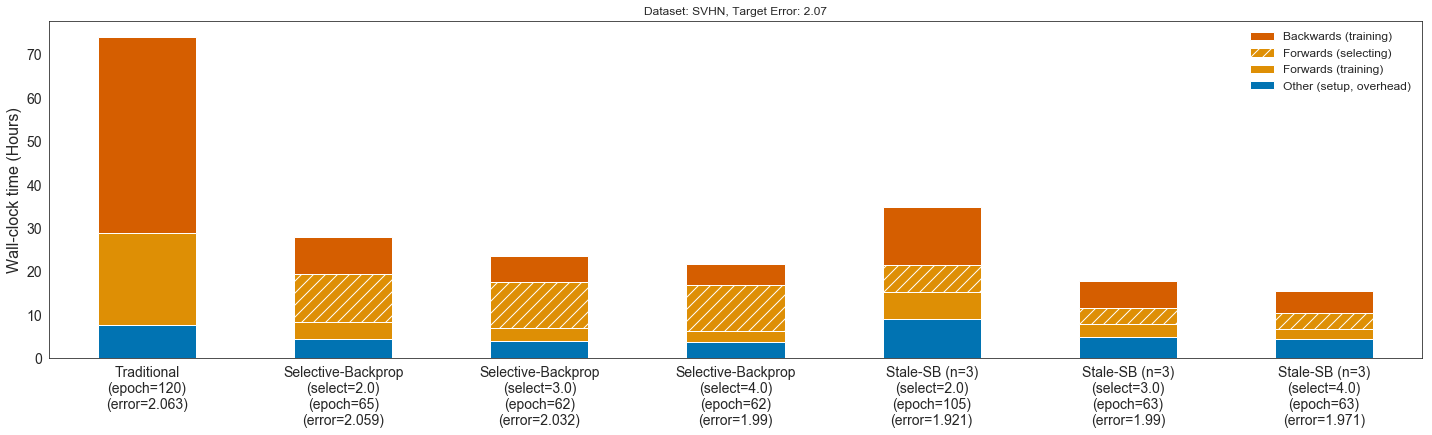

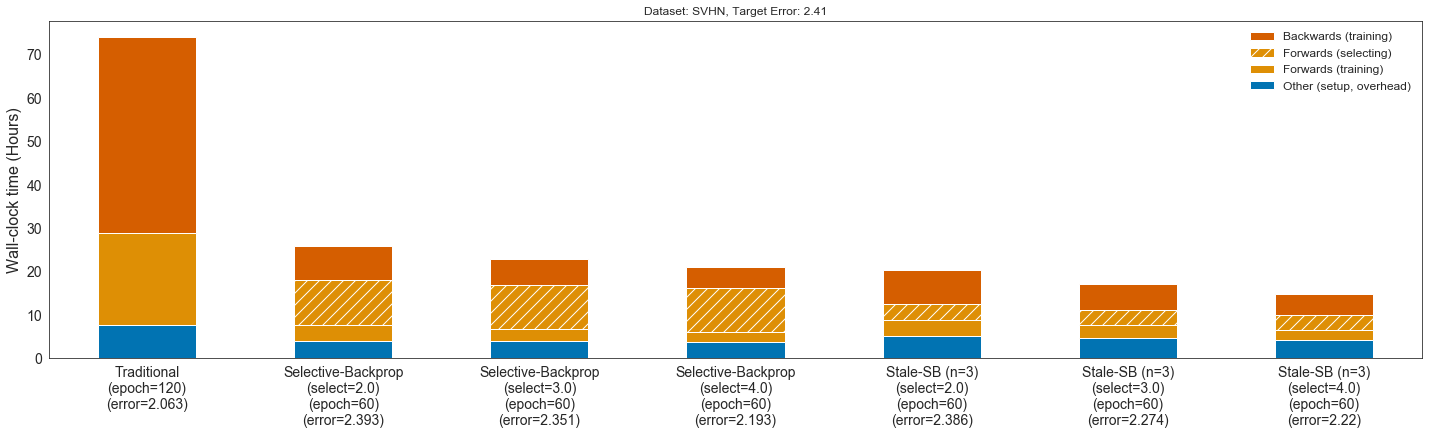

In [515]:
##### df = dfs.values()[0]
def plot_dfs(ds, dfs, target_acc):
    aiee = []
    keys = []
    key_map = {
        'nofilter': 'Traditional',
        'sb-relative-alwayson': 'Selective-Backprop',
        'sb-relative-stale3': 'Stale-SB (n=3)',
    }
    col_map = {
        'est_cum_backward': 'Backwards (training)',
        'est_cum_forward': 'Forwards (training)',
        'est_cum_forwardsb': 'Forwards (selecting)',
        'unaccounted': 'Other (setup, overhead)',
    #     'level_1':'epoch',
    }
    for (select, k), df_ in dfs.items():
#         print(df_)
        df_ = df_[df_['acc'] >= target_acc]
    #     print(df_[['est_cum_backward', 'est_cum_forward', 'est_cum_forwardsb']])
        vals = df_[['est_cum_backward', 'est_cum_forward', 'est_cum_forwardsb']][:1]
        elapsed = df_[['cum_seconds_elapsed']][:1].values[0][0]
        est_total = vals.values.sum()
        unaccounted = elapsed-est_total
        # df_['cum_num_forwards'] * 
        k = k.split("/")[-1].split("_")[0]
        
        epoch = df_[['epoch']][:1].values[0][0]
        acc = df_[['acc']][:1].values[0][0]
        key_map[k + '-' + str(select)] = key_map[k]
        k += '-' + str(select)
        if select != 0:
            key_map[k] += '\n(select={})'.format(select)
        key_map[k] += '\n(epoch={})'.format(epoch)
        key_map[k] += '\n(error={:.4})'.format(100.-acc)
#         print(k)
        keys.append(k)
        vals['unaccounted'] = unaccounted
        vals['epoch'] = epoch
#         print(vals)
        aiee.append(vals / 3600.)
    #     zz
#         print(est_total, elapsed, unaccounted, est_total/elapsed)
#     print(keys)
    dfp = pd.concat(aiee, keys=keys).reset_index(level=1, drop=True)
    dfp = dfp[['unaccounted', 'est_cum_forward', 'est_cum_forwardsb', 'est_cum_backward']]
    dfp = dfp.rename(index=key_map, columns=col_map)
#     ax = dfp.plot.bar(stacked=True, rot=0)
    plt.figure(figsize=(20, 6))
    ax = dfp.plot.bar(stacked=True, ax=plt.gca(), rot=0)
    format_plot("", "Wall-clock time (Hours)")
    # ax.
    dfp

    #  - Backprops (training)
    #  - Forward (training)
    #  - Forward (selecting)
    #  - Other (setup, ...)

    plt.title("Dataset: {}, Target Error: {:.2f}".format(ds.upper(), 100-target_acc))
    kk = 2 * len(dfs)
    for i in range(kk, kk+len(dfs)):
        ax.patches[i].set_hatch('//')
        ax.patches[i].set_facecolor(ax.patches[len(dfs)].get_facecolor())
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(reversed(handles), reversed(labels), prop=dict(size=12), frameon=False)



    # TODO: List the number of epochs at the top
    # TODO: Different colours
    # TODO: good for black and white


    # BASELINE_COLOR = "#e7298a"
    # SB_COLOR = "#66a61e"
    # RANDOM_COLOR = "#7570b3"
    # STALE_COLOR = "#1b9e77"
    # OTHER_COLOR = "#d95f02"


    # Startup cost: first epoch, no filter: data loading
    # look at different selectivities
# plot_dfs(dfs['svhn'], 97.5)


for ds in ['cifar10', 'cifar100', 'svhn']:
#     for select, dcc in dfs[ds].items():
#     dcc = [x[1] for x in dfs[ds]]
    dcc = dfs[ds]
    print(ds, len(dcc))
#     print(dcc.keys())
#     print(dcc)
    accs = e_acc(dcc)
    best_acc = max(accs)
#     plot_dfs(ds, dfs[ds], 0)
    # best
#     plot_dfs(ds, dcc, min(accs))
#     plot_dfs(ds, dfs[ds], 0)
    print(best_acc - min(accs))
    base_acc = accs[0]
    
#     base_acc = min(accs[0])
    try_errors = [100-(100-base_acc)*1.2, 100-(100-base_acc)*1.4]
    for err in try_errors:
        try:
            print(err)
            plot_dfs(ds, dcc, err)
            plot_home_dir = "../plots/"
            plot_dir = "{}/sysml20/money/{}_{}".format(plot_home_dir, ds, err)
            plt.savefig(plot_dir+".pdf")
#             write_file(plot_dir+"")
        except IndexError:
            print("Could not find for {}".format(err))
#     if ds != 'cifar100':
#         plot_dfs(ds, dfs[ds], best_acc - 1)
#     plot_dfs(ds, dfs[ds], best_acc - 2)
#     plot_dfs(ds, dfs[ds], best_acc - 4)
#     plot_dfs(dfs[ds], 100.-(100.-best_acc)*1.1)


(0.0039215686274509803, 0.45098039215686275, 0.69803921568627447, 1.0)